In [1]:
from tqdm import tqdm
from diffusers import DDIMScheduler, UNet2DConditionModel
import argparse
import torch
import warnings
import random
import numpy as np
import mediapy as media
warnings.filterwarnings('ignore')

try:
    from local_model.pipe import LocalStableDiffusionPipeline
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_model.pipe import LocalStableDiffusionPipeline
    
%load_ext autoreload
%autoreload 2

/home/dj/miniconda3/envs/lid/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.set_default_dtype(torch.bfloat16)

used_dtype = torch.bfloat16
model_id = 'CompVis/stable-diffusion-v1-4'

unet = UNet2DConditionModel.from_pretrained(
            model_id, subfolder='unet', torch_dtype=used_dtype
        )
pipe = LocalStableDiffusionPipeline.from_pretrained(
            model_id,
            unet=unet,
            torch_dtype=used_dtype,
            safety_checker=None,
        )
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 14.94it/s]
You have disabled the safety checker for <class 'local_model.pipe.LocalStableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
# load hyperparamters (See Appendix D for details)
parser = argparse.ArgumentParser(description="diffusion memorization")
parser.add_argument("--sd_ver", default=1, type=int)
parser.add_argument("--gen_seed", default=42, type=int)
parser.add_argument("--gen_num", default=4, type=int, help='images for simultaneous generation')
parser.add_argument("--miti_thres", default=8.2, type=float, help='l_thres (refer to Algorithm 2)')
parser.add_argument("--miti_lr", default=0.05, type=float, help='learning rate for latent optimization')
parser.add_argument("--miti_budget", default=8, type=int, help='batch size for simultaneous latent optimization')
parser.add_argument("--miti_max_steps", default=10, type=int, help='max steps for latent optimization (may hurt gaussianity)')
args = parser.parse_args(args=[])


In [4]:
prompt = "If Barbie Were The Face of The World's Most Famous Paintings"
print(prompt)

If Barbie Were The Face of The World's Most Famous Paintings


### Before Mitigation

100%|██████████| 50/50 [00:03<00:00, 16.12it/s]


,,,

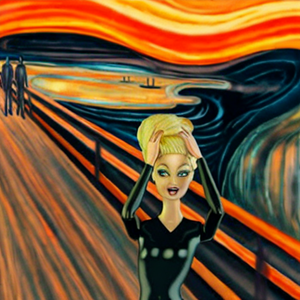
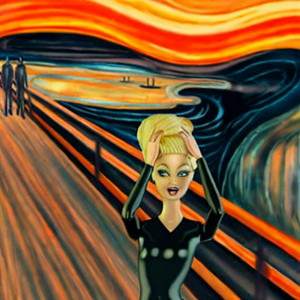
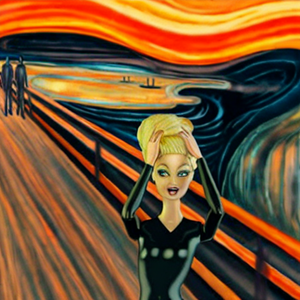
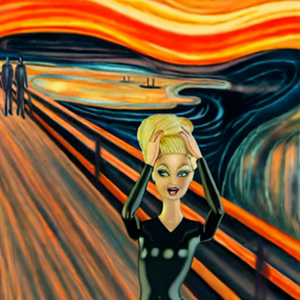

In [5]:
args.exp_type = 'orig'
orig_images = pipe( 
                prompt,
                num_images_per_prompt=args.gen_num,
                args=args
            )
orig_images = orig_images.images
media.show_images(orig_images, width=300)

### After Mitigation

3 Latents Added
5 Latents Added


100%|██████████| 50/50 [00:02<00:00, 16.84it/s]


,,,

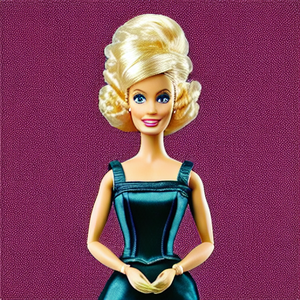
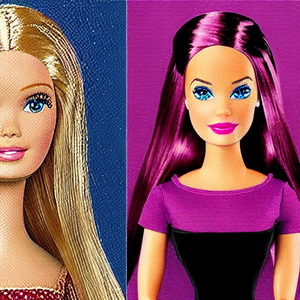
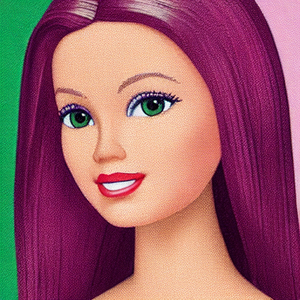
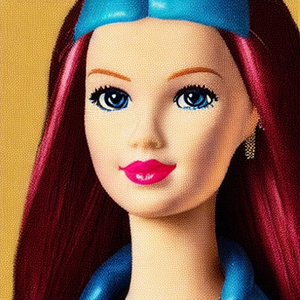

In [6]:
args.exp_type = 'miti'
miti_images = pipe( 
                prompt,
                num_images_per_prompt=args.gen_num,
                args=args
            )
miti_images = miti_images.images
media.show_images(miti_images, width=300)